`Operator` is the foundational building block of the `TorchFSM` library. You can directly call an operator to compute the spatial derivative of a tensor. 

For example, the following code calculates the gradient of `sin(x)` using the `Grad` operator:


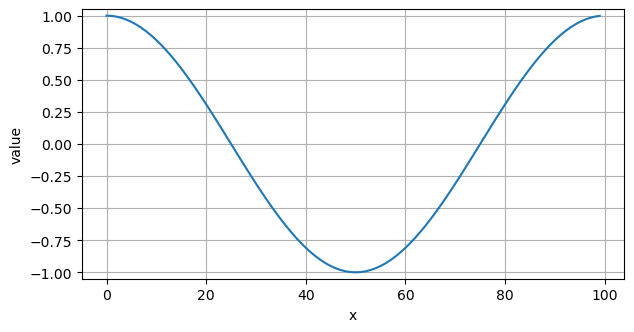

In [1]:
from torchfsm.mesh import MeshGrid
from torchfsm.operator import Grad
from torchfsm.plot import plot_field
import torch

mesh=MeshGrid([(0,2*torch.pi,100)])
sin_x=torch.sin(mesh.bc_mesh_grid())
grad_operator=Grad()
cos_x=grad_operator(sin_x,mesh=mesh)
plot_field(cos_x)

The `__call__` function of an operator can accept additional parameters to improve efficiency. For example:

- It can take input values in Fourier space to avoid repeatedly applying the Fourier transform when the same tensor is used with multiple operators.
- It can also return results in Fourier space for further downstream computations.

For a full list of supported options, refer to the [API documentation](../api/).

Additionally, we provide a `run_operator` function that allows you to apply a list of operators to the same tensor on the same device efficiently. Examples of this usage are shown in the next notebook.

Similar to PyTorch, `TorchFSM` also provides a `torchfsm.functional` module, which includes several commonly used functions. For instance, the code example above can be rewritten using `torchfsm.functional` as follows:


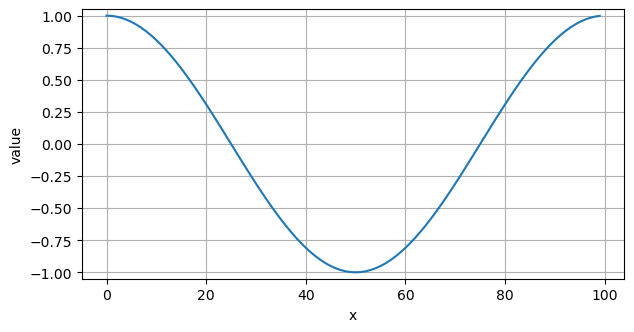

In [2]:
from torchfsm.functional import grad

cos_x=grad(sin_x,mesh=mesh)
plot_field(cos_x)

As mentioned in the [theory introduction](../../theory), one of the major advantages of the Fourier spectral method is its high accuracy. To illustrate this, we can compare its results with those obtained using the finite difference method (FDM).

For the FDM implementation, we use [ConvDO](https://qiauil.github.io/ConvDO/), a library for convolution-based differential operators. In the following example, we compute the gradient of `sin(x)` using both the Fourier spectral method and the FDM, and compare the results across different mesh resolutions.


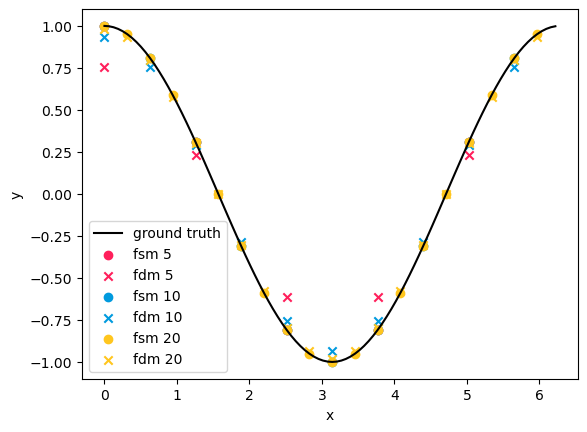

In [35]:
from ConvDO import ConvGrad, ScalarField, PeriodicDomain
from matplotlib import pyplot as plt

mesh=MeshGrid([(0,2*torch.pi,100)])
x=mesh.mesh_grid()
cos_x=torch.cos(x)
plt.plot(x,cos_x.detach().numpy(),label="ground truth",color="black")

ns=[5,10,20]
colors=['#FF1F5B', '#009ADE', '#FFC61E']

for color,n in zip(colors,ns):

    mesh=MeshGrid([(0,2*torch.pi,n)]*2)
    x,y=mesh.bc_mesh_grid()
    x_plot=x[0,0,:,0]
    sin_x=torch.sin(x)
    
    cos_x_fsm=grad(sin_x,mesh=mesh)[0,0,:,0]
    PendingDeprecationWarning
    plt.scatter(x_plot,cos_x_fsm,label=f"fsm {n}",marker="o",color=color)

    # ConvDO has a different definition of the coordinate system, so we need to transpose the result
    u=ScalarField(sin_x.transpose(-1,-2),domain=PeriodicDomain(delta_x=2*torch.pi/n))
    conv_grad=ConvGrad(order=2,direction="x")
    cos_x_fdm=(conv_grad*u).value.transpose(-1,-2)[0,0,:,0]
    plt.scatter(x_plot,cos_x_fdm,label=f"fdm {n}",marker="x",color=color)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

As shown in the example above, the Fourier spectral method converges to the exact solution significantly faster than the finite difference method.